In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import deepcopy
from funciones import CargarPandasDatasetCategoricos

In [2]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [3]:
def comparar_cambio_ranking_dominios(df_ranking, columnas):
    """
    df_ranking: el df de rankings
    columnas:   el nombre de las columnas del df de ranking a comparar, solo 2 o se reconocerán solo las primeras 2
    """
    fluctuacion_ranking = [df_ranking.loc[i,columnas[0]] - df_ranking.loc[i,columnas[1]] for i in df_ranking.index]
    return fluctuacion_ranking

def crear_df_comparacion_nacional_con_dominios(df_ranking, col_referencia):
    df = df = pd.DataFrame(index=df_ranking.index) # crear el nuevo df con las variables como indice
    dominios_a_comparar = list(df_ranking.columns)
    dominios_a_comparar.pop(dominios_a_comparar.index(col_referencia)) #eliminar col_referencia de la lista
    
    for dom in dominios_a_comparar: 
        df[dom] = comparar_cambio_ranking_dominios(df_ranking, [col_referencia,dom])
    return df

def obtener_tamanio_traslape(df_fluctuation):
    for col in df_fluctuation.columns:
        try:
            value = df_fluctuation[col].value_counts()[0]
        except:
            value = 0
        print(f'La cantidad de variables que se mantuvieron en el mismo lugar en {col} fueron {value}')

In [4]:
def GraficarRed(red, positions, metricas_sorted, metrica, localidad, axs, graph_by_ranking, cmap=plt.cm.Blues):
    if graph_by_ranking:
        node_color = [metricas_sorted.index[metricas_sorted[localidad]==col][0] for col in red.nodes]
    else:
        node_color = [v for k,v in red.nodes(data='centralidad')] if metrica=='centralidad' else [v for k,v in red.nodes(data='pagerank')]
        
    nx.draw_networkx_nodes(red, positions, node_size=900, cmap=cmap,
                           node_color=node_color, 
                           ax=axs)
    nx.draw_networkx_labels(red, 
                            {k:[v[0],v[1]+.05] for k,v in positions.items()}, 
                            font_size=38, ax=axs)
    nx.draw_networkx_edges(red, positions, edgelist=red.edges(data='weight'), width=3,
                           node_size=600, arrows=True, arrowsize=50,
                           edge_color=[plt.cm.Greys(e[2]) for e in red.edges(data='weight')], 
                           ax=axs)
    

In [5]:
def GraficarGrafo(red, metricas_sorted, metrica, localidad, fname=None, 
                  positions=None, cmap=plt.cm.Blues, 
                  graph_by_ranking = False):
    if positions==None:
        positions = nx.spring_layout(red, seed=5)
    
    fig, axs = plt.subplots(1, figsize=(30, 15))
    
    GraficarRed(red, positions, metricas_sorted, metrica, localidad, axs, graph_by_ranking, cmap=cmap)
    
    fig.subplots_adjust(bottom=0.01, top=1, left=0, right=1.09)
    """
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), orientation='vertical', 
                        ax=axs, shrink=0.85, ticks=[0, 0.5, 1])
    cbar.set_ticklabels(['bajo', 'medio', 'alto'])
    cbar.ax.tick_params(labelsize=30) 
    """
    
    plt.tight_layout()

    if fname != None:
        plt.savefig(fname, pad_inches=0)
    plt.show()
    return


In [6]:
def EgoRed(grafo_org, n_rows=None, nodes_graf=None, nodes_No_graf=None):
    red = deepcopy(grafo_org)
    
    #seleccionar nodos a graficar
    e=[]
    if nodes_graf != None: # graficar solo los nodos que nos pasan
        e = [e for e in red.nodes if e not in nodes_graf]
    elif nodes_No_graf != None: # graficar solo los nodos que no nos pasan
        e = [e for e in red.nodes if e in nodes_No_graf]
    elif n_rows != None: #graficar solo las primeras n_rows de ranking
        e = [e for e in red.nodes if e not in list(metricas_sorted.head(n_rows)[localidad])]
    red.remove_nodes_from(e)
    
    hub_ego = nx.ego_graph(grafo_org, 'P10_8_abuso')
    hub_ego_atencion = nx.ego_graph(grafo_org, 'P10_8_atencion')
    hub_ego.add_nodes_from(hub_ego_atencion.nodes(data=True))
    hub_ego.add_edges_from(hub_ego_atencion.edges(data=True))
    
    return hub_ego

In [7]:
def GraficarDependencia(G, palette, fname=None):
    lista1 = [(i[1], G.get_edge_data(*i)[0]['weight']) for i in G.out_edges(['P10_8_abuso'])]
    lista2 = [(i[1], G.get_edge_data(*i)[0]['weight']) for i in G.out_edges(['P10_8_atencion'])]

    df1 = pd.DataFrame(sorted(lista1, key=lambda x:x[1])[::-1], columns=['Nodo', 'Abuso y violencia'])
    df2 = pd.DataFrame(lista2, columns=['Nodo', 'Atencion no autorizada'])

    df = pd.merge(df1, df2, on='Nodo', how='outer')
    df['col1'] = df[["Abuso y violencia", "Atencion no autorizada"]].max(axis=1)
    df = df.sort_values(by='col1', ascending=False).drop('col1', axis=1)
    df = pd.melt(df, id_vars='Nodo', value_vars=['Abuso y violencia', 'Atencion no autorizada'], 
                 var_name=' ', value_name='Valor')
    df['Valor'].fillna(0, inplace=True)

    # Configuración de la gráfica
    fig, axes = plt.subplots(figsize=(10,6))
    sns.barplot(x='Valor', y='Nodo', hue=' ', data=df, palette=palette, ax=axes)

    # Etiquetas y título
    plt.xlabel('PFI')
    plt.ylabel('')

    plt.grid(axis='x', alpha=.5)
    axes.set_axisbelow(True)
    
    plt.tight_layout()
    
    # Mostrar la gráfica
    if fname != None:
        plt.savefig(fname, pad_inches=0, bbox_inches='tight') 
    plt.show()

In [8]:
dominio_encoder = ['rural', 'urbano']

## Cargar dataframes

In [9]:
degree_centrality_ranking = pd.read_csv(f'data/degree_centrality_ranking.csv', index_col='Unnamed: 0')
degree_centrality_sorted = pd.read_csv(f'data/degree_centrality_sorted.csv')

pagerank_ranking = pd.read_csv(f'data/pagerank_ranking.csv', index_col='Unnamed: 0')
pagerank_sorted = pd.read_csv(f'data/pagerank_sorted.csv')

In [10]:
degree_centrality_sorted

,rural,urbano
0,CVE_ENT,CVE_ENT
1,MES_PARTO,MES_PARTO
2,BIENES_DE_VIVIENDA,PAREJA_GANANCIAS
3,PAREJA_GANANCIAS,FOCOS
4,PAREN,BIENES_DE_VIVIENDA
5,EDAD,NUM_RESIDENTES
6,SITUACION_CONYUGAL,PAREJA_CUANTO_APORTA_GASTO
7,NUM_RESIDENTES,ESCOLARIDAD
8,CUARTOS_DORMIR,EDAD
9,AGUA,ANIO_PARTO


## Cargar grafos

In [11]:
rural = nx.read_gpickle('data/rural.gpickle')

In [12]:
urbano = nx.read_gpickle('data/urbano.gpickle')

### Rural

In [13]:
nx.is_strongly_connected(rural)

True

In [14]:
[len(c) for c in sorted(nx.strongly_connected_components(rural), key=len, reverse=True)]

[30]

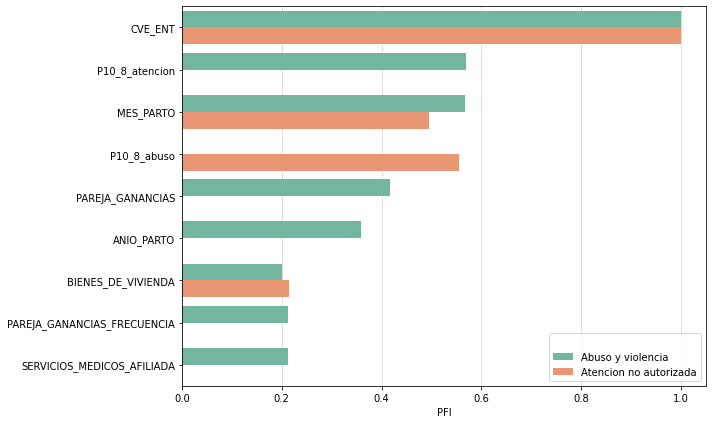

In [15]:
GraficarDependencia(G=rural, palette = 'Set2', 
                    fname='graficas/dependencias_rural.png'
                   )

In [16]:
[(i[0], rural.get_edge_data(*i)[0]['weight']) for i in rural.in_edges(['P10_8_abuso'])]

[('P10_8_atencion', 0.5555942837225513)]

In [17]:
[(i[0], rural.get_edge_data(*i)[0]['weight']) for i in rural.in_edges(['P10_8_atencion'])]

[('P10_8_abuso', 0.5688700748941712),
 ('SERVICIOS_MEDICOS_AFILIADA', 0.19321494831698927)]

### Redes ego

In [18]:
ego_rural = EgoRed(rural)

In [19]:
nx.is_strongly_connected(ego_rural)

False

In [20]:
ego_rural.number_of_edges()

43

In [21]:
ego_rural.number_of_nodes()

9

In [22]:
43/(9*8)

0.5972222222222222

In [23]:
sorted(nx.get_node_attributes(ego_rural, "pagerank").items(), key=lambda x:x[1])[::-1]

[('CVE_ENT', 0.2929540368915536),
 ('MES_PARTO', 0.09893912288841827),
 ('PAREJA_GANANCIAS', 0.05845524916234854),
 ('BIENES_DE_VIVIENDA', 0.03499509064030187),
 ('PAREJA_GANANCIAS_FRECUENCIA', 0.00661408013382156),
 ('P10_8_abuso', 0.006272985566944905),
 ('P10_8_atencion', 0.006107023533206836),
 ('SERVICIOS_MEDICOS_AFILIADA', 0.005785359883481996),
 ('ANIO_PARTO', 0.005542033274494293)]

In [24]:
sorted(nx.get_node_attributes(ego_rural, "centralidad").items(), key=lambda x:x[1])[::-1]

[('CVE_ENT', 0.9310344827586207),
 ('MES_PARTO', 0.7586206896551724),
 ('BIENES_DE_VIVIENDA', 0.3793103448275862),
 ('PAREJA_GANANCIAS', 0.3793103448275862),
 ('PAREJA_GANANCIAS_FRECUENCIA', 0.10344827586206896),
 ('SERVICIOS_MEDICOS_AFILIADA', 0.06896551724137931),
 ('P10_8_atencion', 0.06896551724137931),
 ('P10_8_abuso', 0.034482758620689655),
 ('ANIO_PARTO', 0.034482758620689655)]

In [25]:
print('RURAL')

rural_metricas = {
    'cve' : ['CVE_ENT', 'MES_PARTO', 'PAREJA_GANANCIAS', 'BIENES_DE_VIVIENDA', 'PAREJA_GANANCIAS_FRECUENCIA', 'P10_8_atencion', 'SERVICIOS_MEDICOS_AFILIADA', 'ANIO_PARTO', 'P10_8_abuso'],
    'centralidad' : range(1,10),
    'pagerank' : [1, 2, 3, 4, 5, 7, 8, 9, 6]
}
rural_metricas = pd.DataFrame.from_dict(rural_metricas).set_index('cve',inplace=False)

pagerank_fluctuation = crear_df_comparacion_nacional_con_dominios(rural_metricas, 'centralidad')
obtener_tamanio_traslape(pagerank_fluctuation)
pagerank_fluctuation.columns = ['dif']
pr_fluct = rural_metricas.join(pagerank_fluctuation)
pr_fluct['diff_abs'] = pr_fluct['dif'].abs()
pr_fluct.columns = ['centralidad','pagerank','Diferencia','diff_abs']
pr_fluct.sort_values(by='diff_abs', ascending=False)[['centralidad','pagerank','Diferencia']]

RURAL
La cantidad de variables que se mantuvieron en el mismo lugar en pagerank fueron 5


,centralidad,pagerank,Diferencia
cve,,,
P10_8_abuso,9,6,3
P10_8_atencion,6,7,-1
SERVICIOS_MEDICOS_AFILIADA,7,8,-1
ANIO_PARTO,8,9,-1
CVE_ENT,1,1,0
MES_PARTO,2,2,0
PAREJA_GANANCIAS,3,3,0
BIENES_DE_VIVIENDA,4,4,0
PAREJA_GANANCIAS_FRECUENCIA,5,5,0


### Urbano


In [26]:
nx.is_strongly_connected(urbano)

True

In [27]:
[len(c) for c in sorted(nx.strongly_connected_components(urbano), key=len, reverse=True)]

[39]

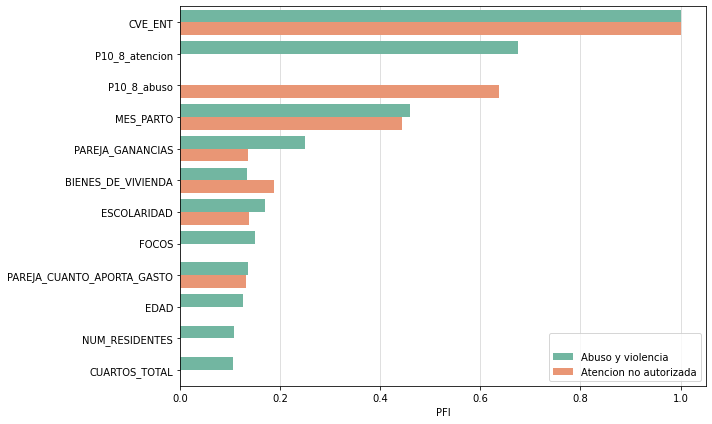

In [28]:
GraficarDependencia(G=urbano, palette='Set2', 
                    fname='graficas/dependencias_urbano.png'
                   )

In [29]:
[(i[0], urbano.get_edge_data(*i)[0]['weight']) for i in urbano.in_edges(['P10_8_abuso'])]

[('PERT_INDIGENA', 0.10452508312852381), ('P10_8_atencion', 0.637250453720508)]

In [30]:
[(i[0], urbano.get_edge_data(*i)[0]['weight']) for i in urbano.in_edges(['P10_8_atencion'])]

[('P10_8_abuso', 0.6759089720115091)]

### Redes ego

In [31]:
ego_urbano = EgoRed(urbano)

In [32]:
nx.is_strongly_connected(ego_urbano)

False

In [33]:
ego_urbano.number_of_edges()

101

In [34]:
ego_urbano.number_of_nodes()

12

In [35]:
101/(12*11)

0.7651515151515151

In [36]:
sorted(nx.get_node_attributes(ego_urbano, "pagerank").items(), key=lambda x:x[1])[::-1]

[('CVE_ENT', 0.20339555531500045),
 ('PAREJA_GANANCIAS', 0.08660351149661279),
 ('MES_PARTO', 0.07655983335233332),
 ('BIENES_DE_VIVIENDA', 0.04679697423423722),
 ('FOCOS', 0.04536289190169624),
 ('PAREJA_CUANTO_APORTA_GASTO', 0.031215347656526664),
 ('ESCOLARIDAD', 0.025496222188048513),
 ('NUM_RESIDENTES', 0.023963954139085232),
 ('CUARTOS_TOTAL', 0.023579075098693773),
 ('EDAD', 0.018005360078443788),
 ('P10_8_abuso', 0.004940728507734735),
 ('P10_8_atencion', 0.004702718381191229)]

In [37]:
sorted(nx.get_node_attributes(ego_urbano, "centralidad").items(), key=lambda x:x[1])[::-1]

[('CVE_ENT', 0.9210526315789473),
 ('MES_PARTO', 0.7368421052631579),
 ('PAREJA_GANANCIAS', 0.631578947368421),
 ('FOCOS', 0.5),
 ('BIENES_DE_VIVIENDA', 0.5),
 ('NUM_RESIDENTES', 0.47368421052631576),
 ('PAREJA_CUANTO_APORTA_GASTO', 0.42105263157894735),
 ('ESCOLARIDAD', 0.3421052631578947),
 ('EDAD', 0.2894736842105263),
 ('CUARTOS_TOTAL', 0.2631578947368421),
 ('P10_8_abuso', 0.05263157894736842),
 ('P10_8_atencion', 0.02631578947368421)]

In [38]:
print('URBANO')

urbano_metricas = {
    'cve' : ['CVE_ENT', 'MES_PARTO', 'PAREJA_GANANCIAS', 'FOCOS', 'BIENES_DE_VIVIENDA', 'NUM_RESIDENTES', 'PAREJA_CUANTO_APORTA_GASTO', 'ESCOLARIDAD', 'EDAD', 'CUARTOS_TOTAL', 'P10_8_abuso', 'P10_8_atencion'],
    'centralidad' : range(1,13),
    'pagerank' : [1, 3, 2, 5, 4, 8, 6, 7, 10, 9, 11, 12]
}
urbano_metricas = pd.DataFrame.from_dict(urbano_metricas).set_index('cve',inplace=False)

pagerank_fluctuation = crear_df_comparacion_nacional_con_dominios(urbano_metricas, 'centralidad')
obtener_tamanio_traslape(pagerank_fluctuation)
pagerank_fluctuation.columns = ['dif']
pr_fluct = urbano_metricas.join(pagerank_fluctuation)
pr_fluct['diff_abs'] = pr_fluct['dif'].abs()
pr_fluct.columns = ['centralidad','pagerank','Diferencia','diff_abs']
pr_fluct.sort_values(by='diff_abs', ascending=False)[['centralidad','pagerank','Diferencia']]

URBANO
La cantidad de variables que se mantuvieron en el mismo lugar en pagerank fueron 3


,centralidad,pagerank,Diferencia
cve,,,
NUM_RESIDENTES,6,8,-2
MES_PARTO,2,3,-1
PAREJA_GANANCIAS,3,2,1
FOCOS,4,5,-1
BIENES_DE_VIVIENDA,5,4,1
PAREJA_CUANTO_APORTA_GASTO,7,6,1
ESCOLARIDAD,8,7,1
EDAD,9,10,-1
CUARTOS_TOTAL,10,9,1


In [39]:
ambos = rural_metricas.join(urbano_metricas, lsuffix='_rural', rsuffix='_urbano').dropna()
ambos

,centralidad_rural,pagerank_rural,centralidad_urbano,pagerank_urbano
cve,,,,
CVE_ENT,1,1,1.0,1.0
MES_PARTO,2,2,2.0,3.0
PAREJA_GANANCIAS,3,3,3.0,2.0
BIENES_DE_VIVIENDA,4,4,5.0,4.0
P10_8_atencion,6,7,12.0,12.0
P10_8_abuso,9,6,11.0,11.0


In [40]:
print('CENTRALIDAD')

degree_fluctuation = crear_df_comparacion_nacional_con_dominios(ambos[['centralidad_urbano','centralidad_rural']], 'centralidad_rural')
obtener_tamanio_traslape(degree_fluctuation)
degree_fluctuation.columns = ['dif']
dc_fluct = ambos[['centralidad_urbano','centralidad_rural']].join(degree_fluctuation)
dc_fluct['diff_abs'] = dc_fluct['dif'].abs()
dc_fluct.columns = ['centralidad_urbano','centralidad_rural','Diferencia','diff_abs']
dc_fluct.sort_values(by='diff_abs', ascending=False)[['centralidad_rural','centralidad_urbano','Diferencia']]

CENTRALIDAD
La cantidad de variables que se mantuvieron en el mismo lugar en centralidad_urbano fueron 3


,centralidad_rural,centralidad_urbano,Diferencia
cve,,,
P10_8_atencion,6,12.0,-6.0
P10_8_abuso,9,11.0,-2.0
BIENES_DE_VIVIENDA,4,5.0,-1.0
CVE_ENT,1,1.0,0.0
MES_PARTO,2,2.0,0.0
PAREJA_GANANCIAS,3,3.0,0.0


In [41]:
print('PAGERANK')

pagerank_fluctuation = crear_df_comparacion_nacional_con_dominios(ambos[['pagerank_urbano','pagerank_rural']], 'pagerank_rural')
obtener_tamanio_traslape(pagerank_fluctuation)
pagerank_fluctuation.columns = ['dif']
pr_fluct = ambos[['centralidad_urbano','centralidad_rural']].join(pagerank_fluctuation)
pr_fluct['diff_abs'] = pr_fluct['dif'].abs()
pr_fluct.columns = ['pagerank_urbano','pagerank_rural','Diferencia','diff_abs']
pr_fluct.sort_values(by='diff_abs', ascending=False)[['pagerank_rural','pagerank_urbano','Diferencia']]

PAGERANK
La cantidad de variables que se mantuvieron en el mismo lugar en pagerank_urbano fueron 2


,pagerank_rural,pagerank_urbano,Diferencia
cve,,,
P10_8_atencion,6,12.0,-5.0
P10_8_abuso,9,11.0,-5.0
MES_PARTO,2,2.0,-1.0
PAREJA_GANANCIAS,3,3.0,1.0
CVE_ENT,1,1.0,0.0
BIENES_DE_VIVIENDA,4,5.0,0.0


## Graficar centralidad de grado

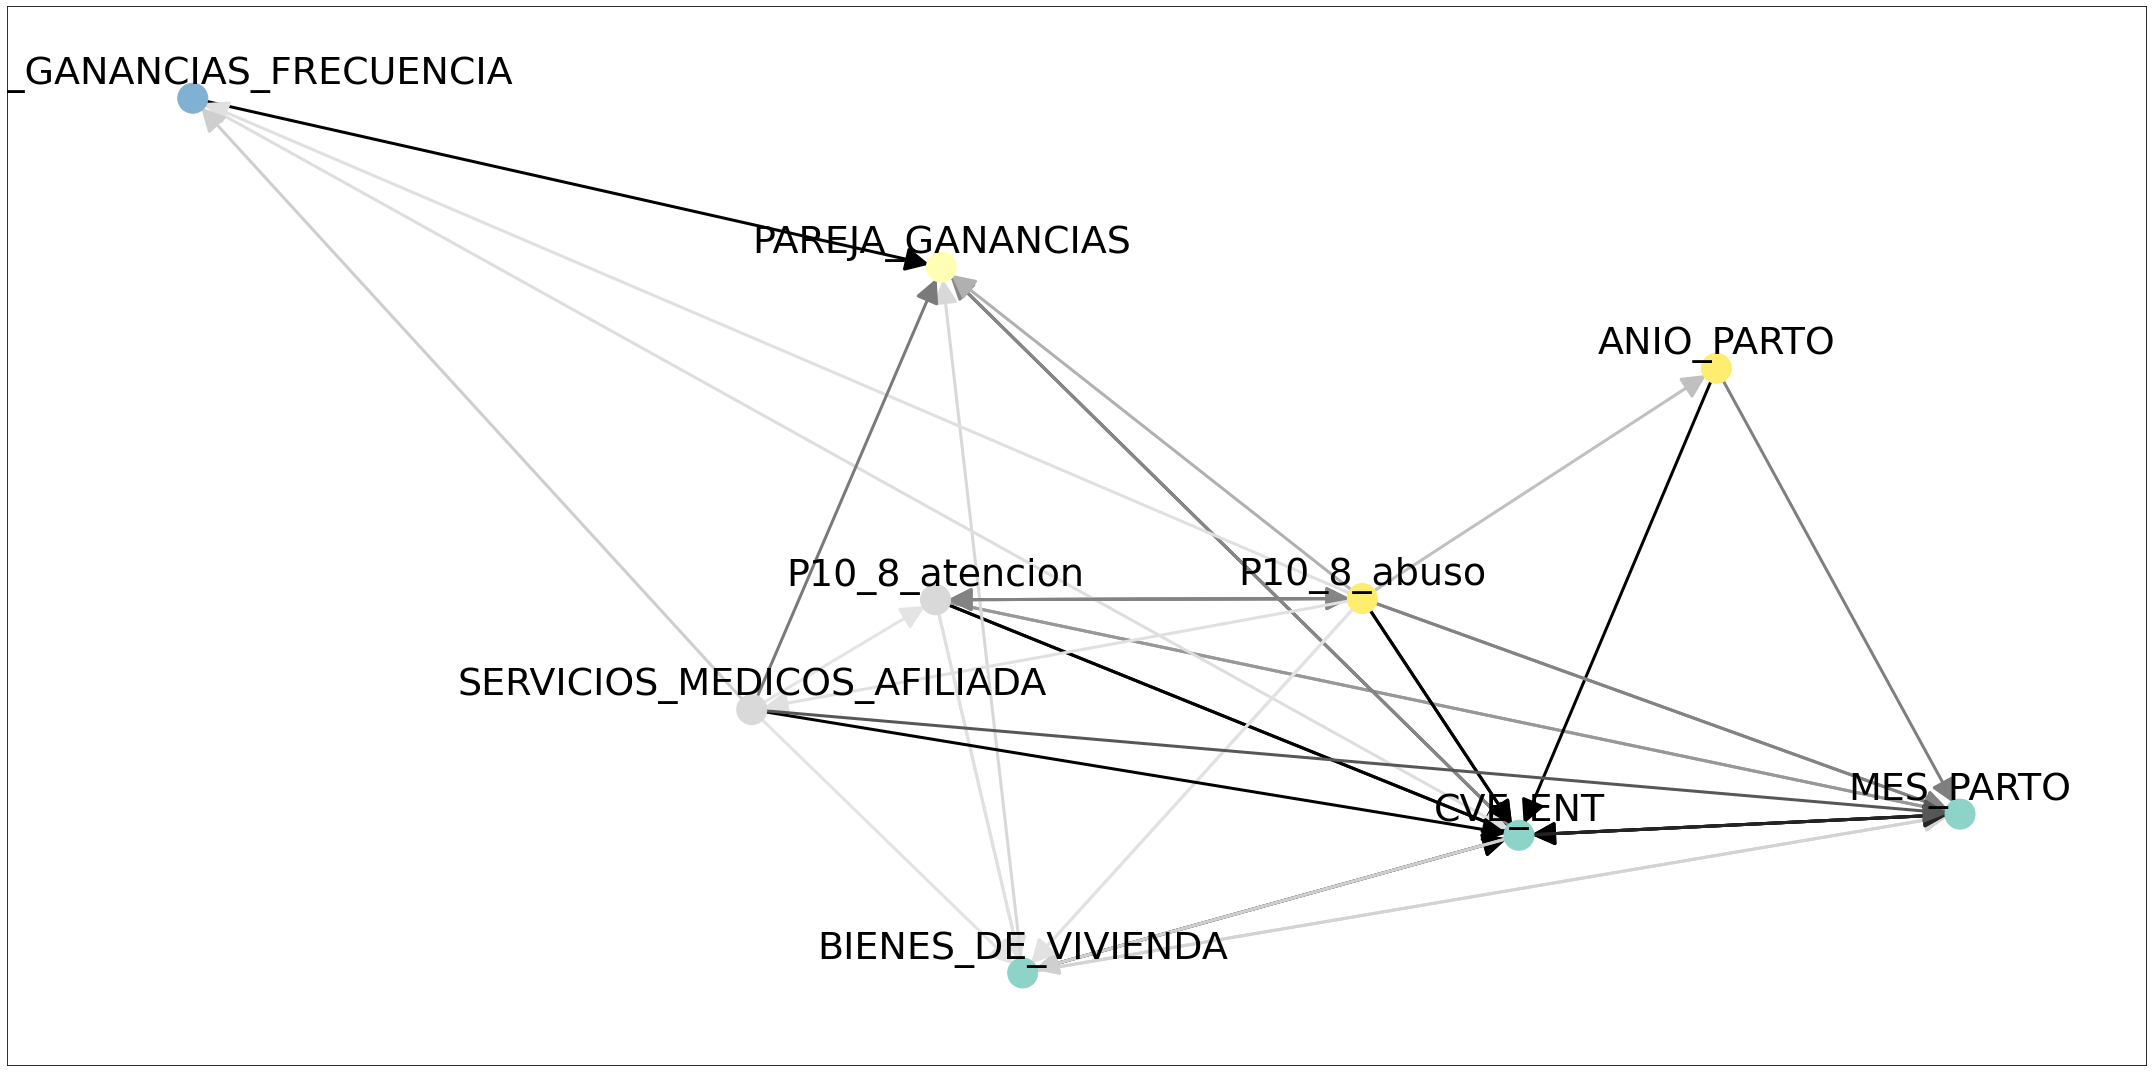

In [43]:
GraficarGrafo(ego_rural, degree_centrality_sorted, 'centralidad', 
              fname = 'graficas/ego_rural_grado.png',
              localidad = 'rural', 
              #positions=positions,
              cmap = plt.cm.get_cmap('Set3'),
              graph_by_ranking = True
             )

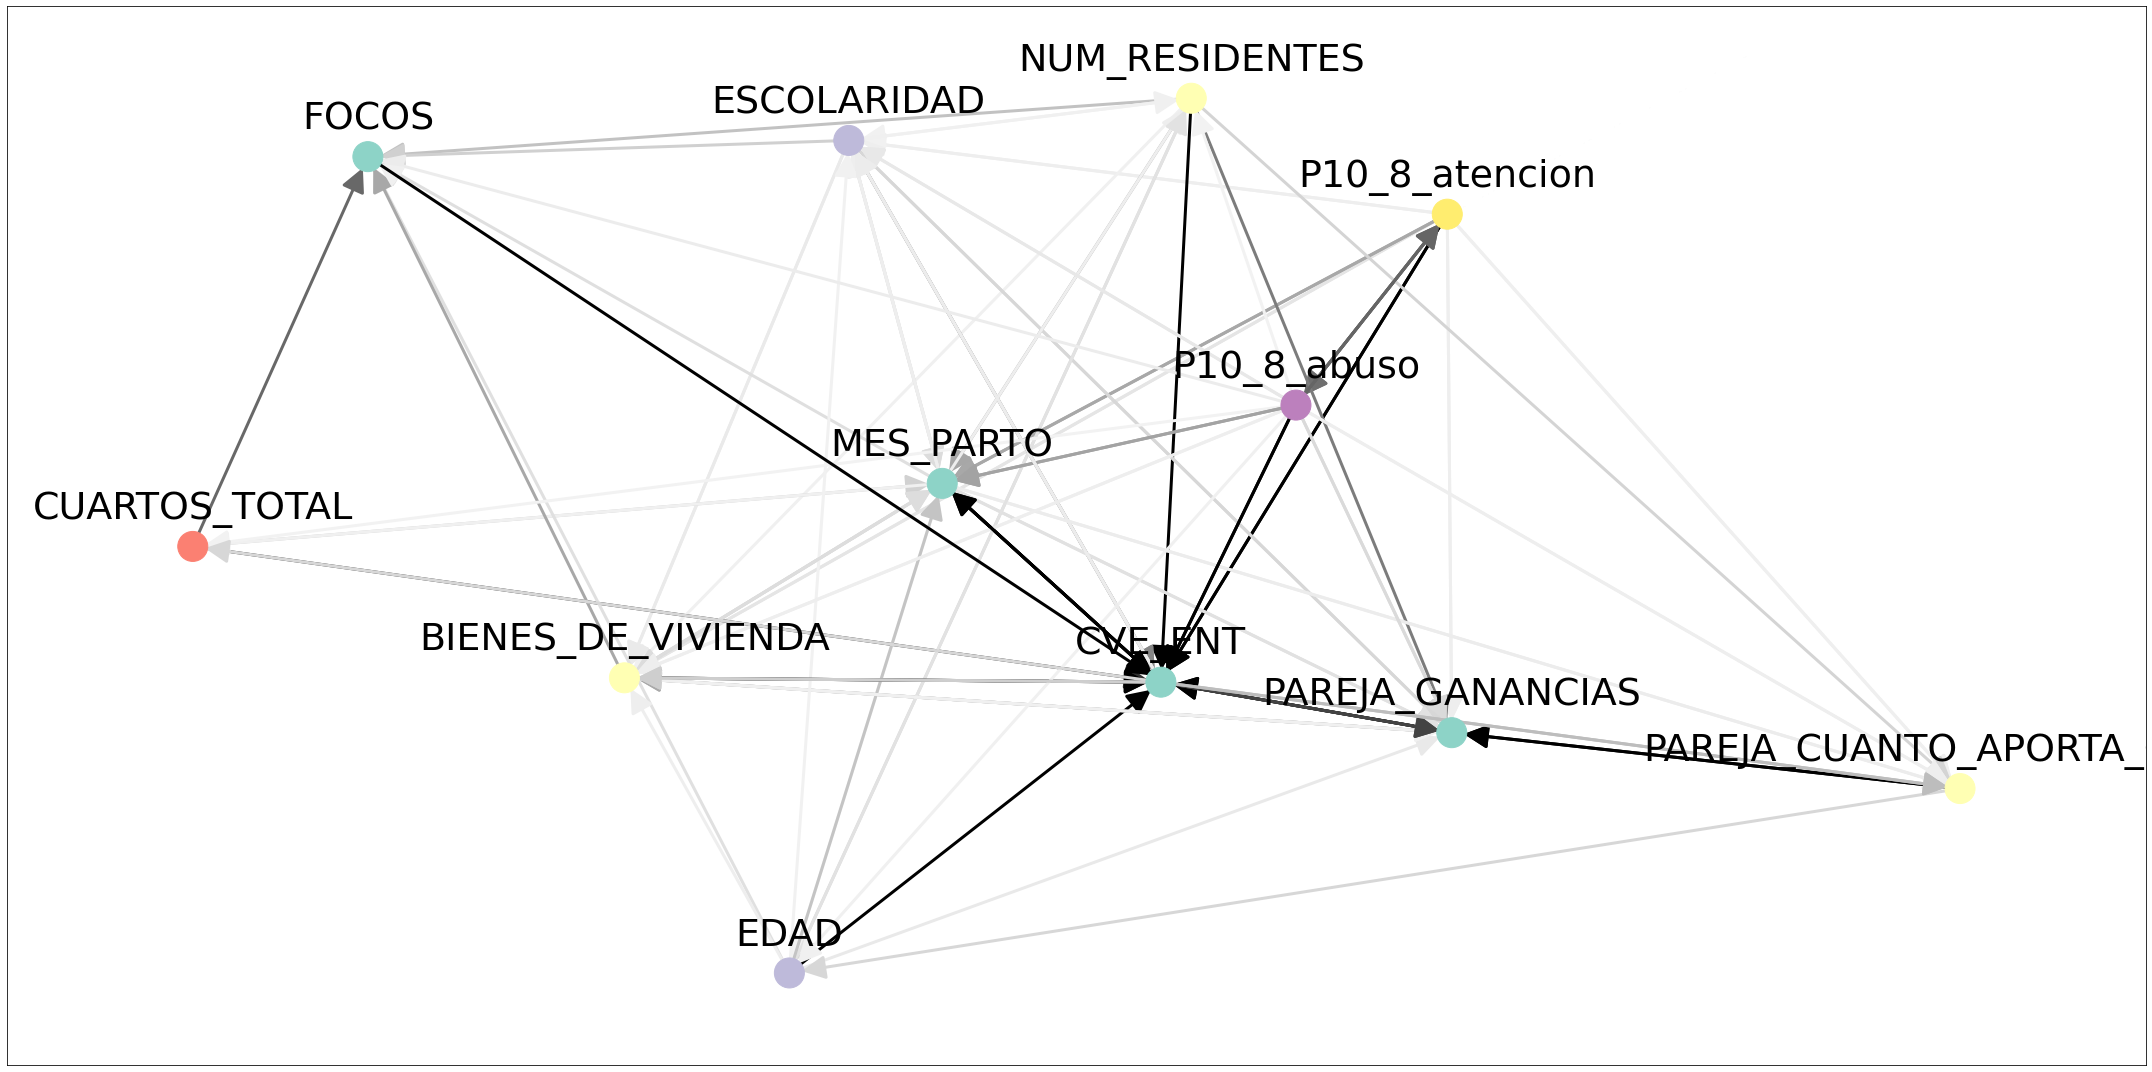

In [44]:
GraficarGrafo(ego_urbano, degree_centrality_sorted, 'centralidad', 
              fname = 'graficas/ego_urbano_grado.png',
              localidad = 'urbano',
              cmap = plt.cm.get_cmap('Set3'),
              graph_by_ranking = True
             )

## Graficar <em>pagerank</em>

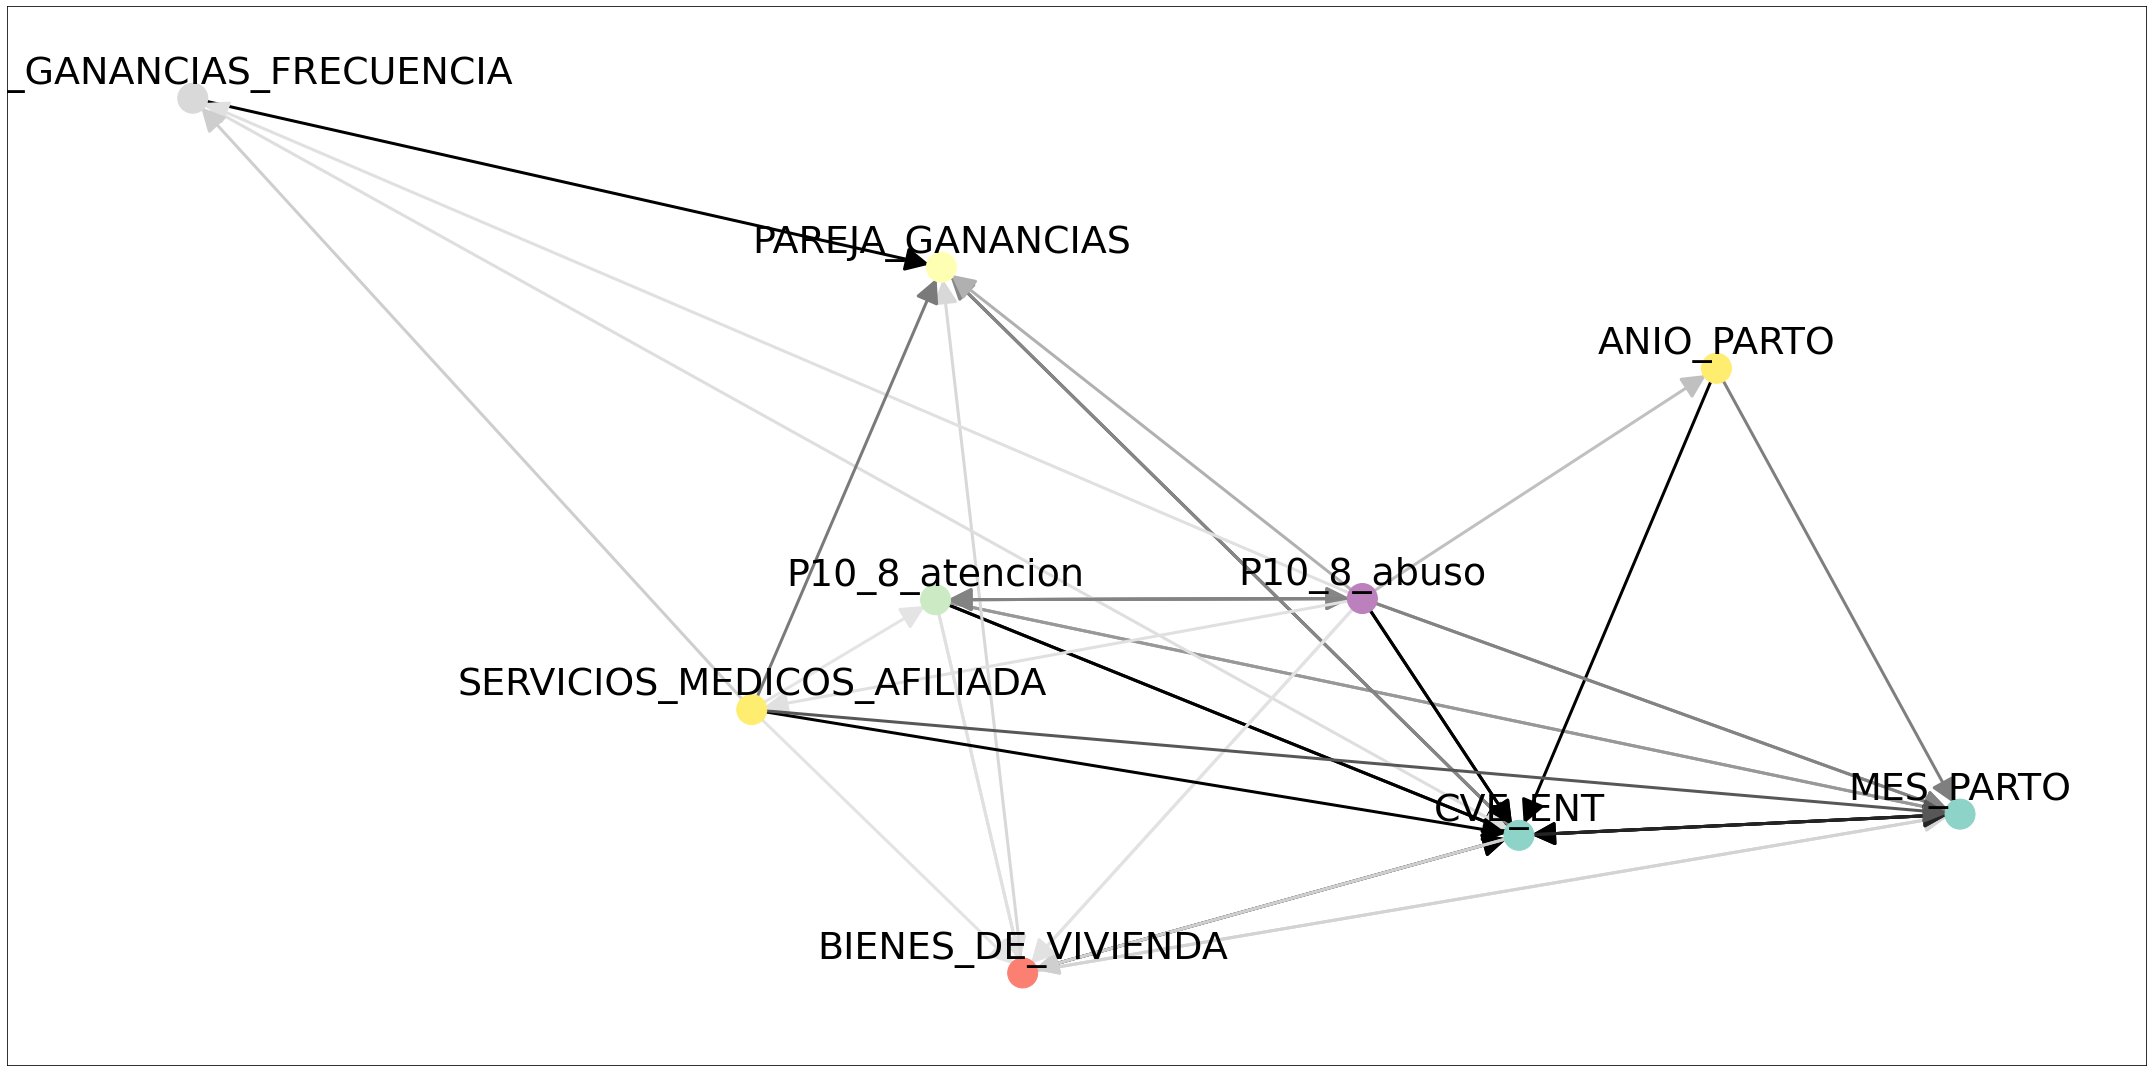

In [45]:
GraficarGrafo(ego_rural, pagerank_sorted, 'pagerank', 
              fname = 'graficas/ego_rural_pagerank.png',
              localidad = 'rural',
              cmap = plt.cm.get_cmap('Set3'),
              graph_by_ranking = True
             )

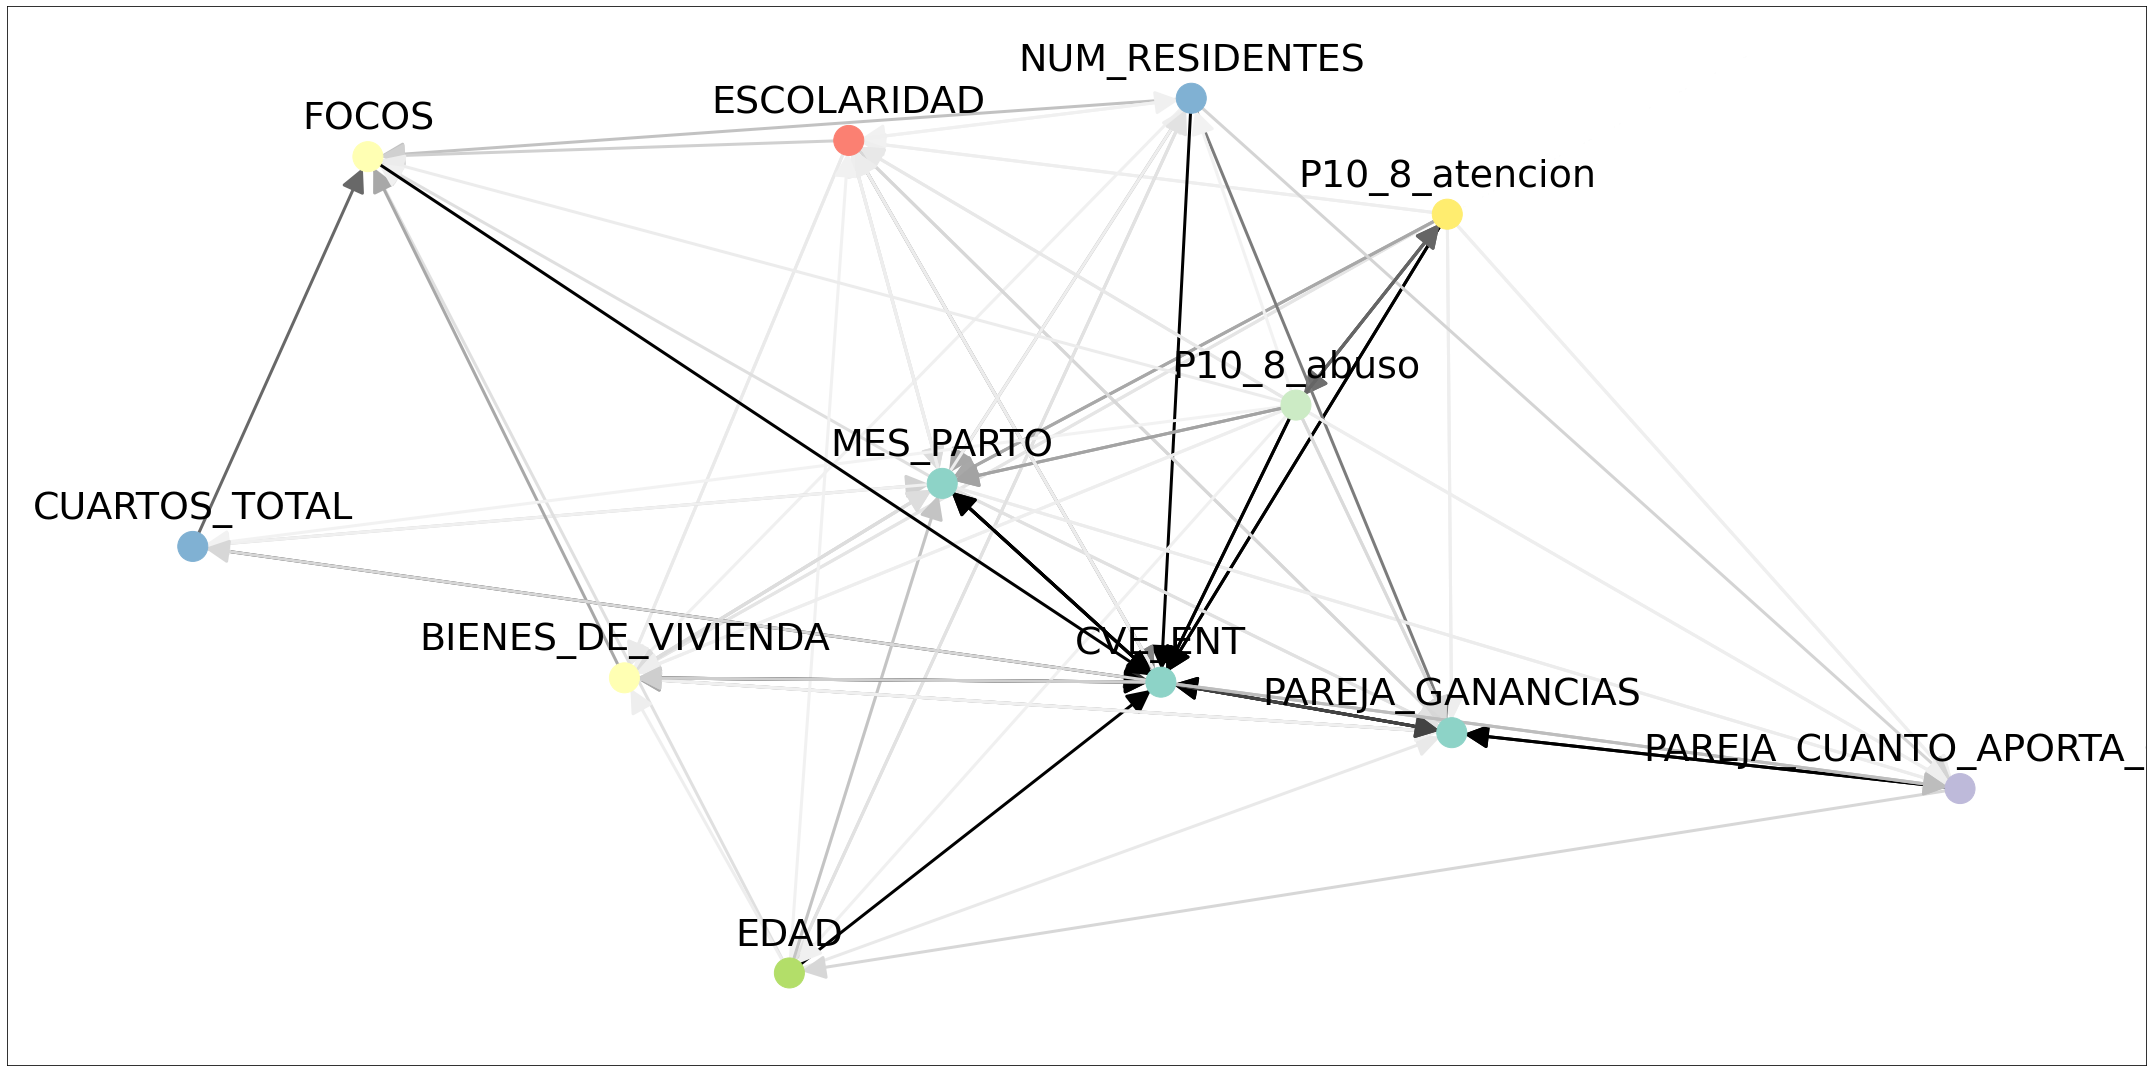

In [46]:
GraficarGrafo(ego_urbano, pagerank_sorted, 'pagerank',
              fname = 'graficas/ego_urbano_pagerank.png',
              localidad = 'urbano',
              cmap = plt.cm.get_cmap('Set3'),
              graph_by_ranking = True
             )